In [45]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display
plt.rc('font', family='Verdana')

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

In [46]:
data = DataFrame.from_csv('data/processed_data.csv', encoding='utf-8')
data.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,...,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,AGE_CATEGORY,WITHOUT_DELAY,REG_ADDRESS_PROVINCE_FREQ,FACT_ADDRESS_PROVINCE_FREQ,SOLVENCY
0,0,49,0,0,0,0,0,0,0,0,...,2,1,1580.000000,1580.0,0.0,0,0,253,250,3.750000
1,0,32,0,0,0,1,1,1,0,0,...,1,1,4020.000000,4020.0,0.0,1,0,127,127,3.325635
2,0,52,0,0,0,2,2,2,0,1,...,0,0,0.000000,0.0,0.0,2,1,202,203,3.260279
3,0,39,0,0,0,3,0,3,0,2,...,3,1,1589.923333,1590.0,0.0,1,0,407,404,17.664058
4,0,30,0,0,1,4,2,1,0,3,...,2,1,1152.150000,2230.0,0.0,3,0,127,127,6.548431


In [47]:
data.shape

(15223, 55)

In [48]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [83]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 25, 50, 100, 150, 200, 250, 300]

for ntrees in trees_grid:
    rf = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_acc.append(rf.score(X_train, y_train))
        temp_test_acc.append(rf.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшее значение правильности перекрестной проверки равно {:.2f}% и достигается при {} деревьях".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшее значение правильности перекрестной проверки равно 88.09% и достигается при 300 деревьях


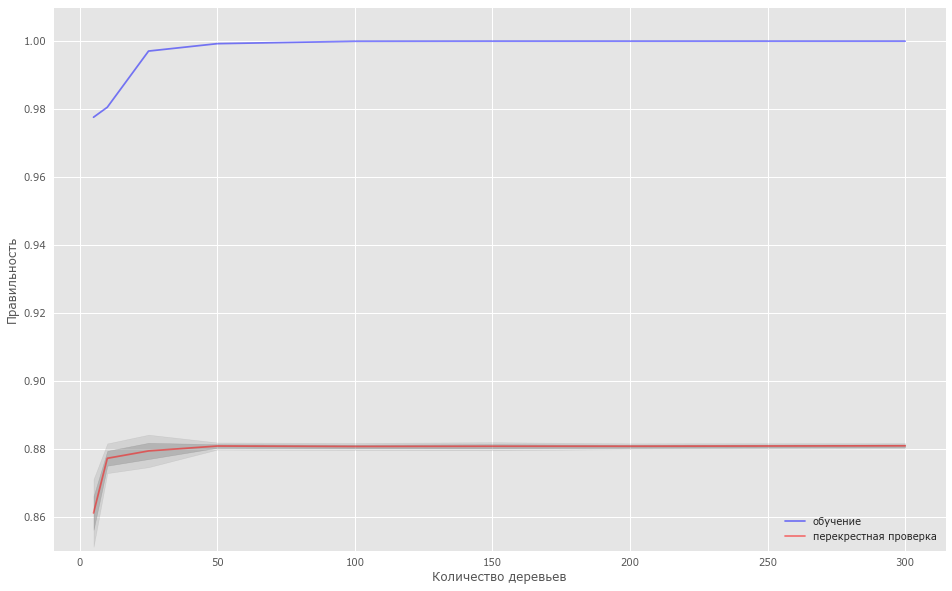

In [50]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', 
        label='обучение')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', 
        label='перекрестная проверка')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.85,1.01])
ax.set_ylabel("Правильность")
ax.set_xlabel("Количество деревьев")

In [51]:
n_trees = 75

In [91]:
param_grid = {'max_features': [3, 4, 5, 6, 7, 8, 9, 12, 15, 18, 21], 'max_depth': [6, 8, 10, 12, 14, 16, 18, 20, 22]}

In [82]:
rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
grid_search = GridSearchCV(rf, param_grid, n_jobs=-1, cv=strat)
grid_search.fit(X_trainval, y_trainval)
test_score = roc_auc_score(y_test, grid_search.predict(X_test))
print("AUC на тестовой выборке: {:.2f}".format(test_score))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

AUC на тестовой выборке: 0.50
Наилучшие значения параметров: {'max_depth': 20, 'max_features': 5}


In [84]:
rf.predict_proba(X_test)[:, 1]

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [70]:
rf.fit(X_trainval, y_trainval)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [85]:
rf = RandomForestClassifier(max_depth=20, max_features=5, n_estimators=75, n_jobs=-1, random_state=42)

In [87]:
rf.fit(X_trainval, y_trainval)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [92]:
rf.predict_proba(X_test)

array([[ 0.66442029,  0.33557971],
       [ 0.57192982,  0.42807018],
       [ 0.7539211 ,  0.2460789 ],
       ..., 
       [ 0.81246147,  0.18753853],
       [ 0.92095655,  0.07904345],
       [ 0.89440385,  0.10559615]])

In [94]:
auc_score = roc_auc_score(y_test, rf.predict(X_test))

In [95]:
auc_score

0.49975074775672979

In [65]:
# X_train, X_control, y_train, y_control = train_test_split(X, y, random_state=42)
# print("Размер обучающей выборки: {} размер контрольной выборки: {}".format(X_train.shape[0], X_control.shape[0]))

best_score = 0

for max_depth in [10, 12, 14, 16, 18, 20, 22]:
    for max_features in [3, 6, 9, 12, 15, 18, 21]:
        # для каждой комбинации параметров обучаем случайный лес
        rf = RandomForestClassifier(max_depth=max_depth, max_features=max_features,  
                                    n_estimators=75, n_jobs=-1, random_state=42)
        rf.fit(X_trainval, y_train)
        # оцениваем качество случайного леса на контрольной выборке
        auc_score = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
        # если получаем наилучшее значение AUC, сохраняем значение и параметры
        if auc_score > best_score:
            best_score = auc_score
            best_parameters = {'max_features': max_features, 'max_depth': max_depth}

print("Наилучшее значение AUC: {:.2f}".format(best_score))
print("Наилучшие значения параметров: {}".format(best_parameters))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10d601db0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10d601db0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/anaconda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/anaconda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 10, 2, 14, 5, 57, 974677, tzinfo=datetime.timezone.utc), 'msg_id': '420F762FDE4C4BE28044A8813F08AB4F', 'msg_type': 'execute_request', 'session': '2A275897F2D84C0DA0C7F6C48957C492', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '420F762FDE4C4BE28044A8813F08AB4F', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2A275897F2D84C0DA0C7F6C48957C492']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 10, 2, 14, 5, 57, 974677, tzinfo=datetime.timezone.utc), 'msg_id': '420F762FDE4C4BE28044A8813F08AB4F', 'msg_type': 'execute_request', 'session': '2A275897F2D84C0DA0C7F6C48957C492', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '420F762FDE4C4BE28044A8813F08AB4F', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2A275897F2D84C0DA0C7F6C48957C492'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 10, 2, 14, 5, 57, 974677, tzinfo=datetime.timezone.utc), 'msg_id': '420F762FDE4C4BE28044A8813F08AB4F', 'msg_type': 'execute_request', 'session': '2A275897F2D84C0DA0C7F6C48957C492', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '420F762FDE4C4BE28044A8813F08AB4F', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# X_train, X_control, y_train, y_control = train...значения параметров: {}".format(best_parameters))', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.For object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-65-dae384ae89c3>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 139d2b1d0, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x13cedadb0, file "<ipython-input-65-dae384ae89c3>", line 6>
        result = <ExecutionResult object at 139d2b1d0, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x13cedadb0, file "<ipython-input-65-dae384ae89c3>", line 6>, result=<ExecutionResult object at 139d2b1d0, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x13cedadb0, file "<ipython-input-65-dae384ae89c3>", line 6>
        self.user_global_ns = {'DataFrame': <class 'pandas.core.frame.DataFrame'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np\nimport pandas as pd\nfrom pand...emble import RandomForestClassifier\nfrom sklearn.', 'import numpy as np\nimport pandas as pd\nfrom pand...m sklearn.model_selection import train_test_split', "data = DataFrame.from_csv('data/processed_data.csv', encoding='utf-8')\ndata.head()", 'import numpy as np\nimport pandas as pd\nfrom pand...m sklearn.model_selection import train_test_split', "X_train, X_test, y_train, y_test = train_test_sp...ARGET', axis=1), data['TARGET'], random_state=42)", 'logreg = LogisticRegression()', 'logreg.fit(X_train, y_train)', 'logreg.score()', 'logreg.score(X_test, y_test)', 'data.shape', "data['TARGET']", 'logreg.predict(y_test)', 'logreg.predict(X_test)', '# Из модуля sklearn.metrics импортируем функцию ... для контрольной выборки: {:.3f}".format(rf_auc))', '# Из модуля sklearn.metrics импортируем функцию ... для контрольной выборки: {:.3f}".format(rf_auc))', 'forest = RandomForestClassifier()\nforest.fit(X_t... для контрольной выборки: {:.3f}".format(rf_auc))', 'forest.oob_score()', 'forest.oob_score_', 'forest = RandomForestClassifier(n_estimators=500... для контрольной выборки: {:.3f}".format(rf_auc))', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {3:    TARGET  AGE  SOCSTATUS_WORK_FL  SOCSTATUS_PEN...          127   6.548431  

[5 rows x 55 columns], 7: LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), 9: 0.87861271676300579, 10: (15223, 55), 11: 0        0
1        0
2        0
3        0
4   ...22    0
Name: TARGET, Length: 15223, dtype: int64, 13: array([0, 0, 0, ..., 0, 0, 0]), 20: 0.88096697906630461, 28: <matplotlib.text.Text object>, 29: <matplotlib.text.Text object>, 30: <matplotlib.text.Text object>, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'Series': <class 'pandas.core.series.Series'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'X':        AGE  SOCSTATUS_WORK_FL  SOCSTATUS_PENS_FL...8  
15222  11.713031  

[15223 rows x 54 columns], ...}
        self.user_ns = {'DataFrame': <class 'pandas.core.frame.DataFrame'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np\nimport pandas as pd\nfrom pand...emble import RandomForestClassifier\nfrom sklearn.', 'import numpy as np\nimport pandas as pd\nfrom pand...m sklearn.model_selection import train_test_split', "data = DataFrame.from_csv('data/processed_data.csv', encoding='utf-8')\ndata.head()", 'import numpy as np\nimport pandas as pd\nfrom pand...m sklearn.model_selection import train_test_split', "X_train, X_test, y_train, y_test = train_test_sp...ARGET', axis=1), data['TARGET'], random_state=42)", 'logreg = LogisticRegression()', 'logreg.fit(X_train, y_train)', 'logreg.score()', 'logreg.score(X_test, y_test)', 'data.shape', "data['TARGET']", 'logreg.predict(y_test)', 'logreg.predict(X_test)', '# Из модуля sklearn.metrics импортируем функцию ... для контрольной выборки: {:.3f}".format(rf_auc))', '# Из модуля sklearn.metrics импортируем функцию ... для контрольной выборки: {:.3f}".format(rf_auc))', 'forest = RandomForestClassifier()\nforest.fit(X_t... для контрольной выборки: {:.3f}".format(rf_auc))', 'forest.oob_score()', 'forest.oob_score_', 'forest = RandomForestClassifier(n_estimators=500... для контрольной выборки: {:.3f}".format(rf_auc))', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {3:    TARGET  AGE  SOCSTATUS_WORK_FL  SOCSTATUS_PEN...          127   6.548431  

[5 rows x 55 columns], 7: LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), 9: 0.87861271676300579, 10: (15223, 55), 11: 0        0
1        0
2        0
3        0
4   ...22    0
Name: TARGET, Length: 15223, dtype: int64, 13: array([0, 0, 0, ..., 0, 0, 0]), 20: 0.88096697906630461, 28: <matplotlib.text.Text object>, 29: <matplotlib.text.Text object>, 30: <matplotlib.text.Text object>, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'Series': <class 'pandas.core.series.Series'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'X':        AGE  SOCSTATUS_WORK_FL  SOCSTATUS_PENS_FL...8  
15222  11.713031  

[15223 rows x 54 columns], ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/boriszubarev/Desktop/RoadToDataScientist/contests/OTP_bank/<ipython-input-65-dae384ae89c3> in <module>()
      6 for max_depth in [10, 12, 14, 16, 18, 20, 22]:
      7     for max_features in [3, 6, 9, 12, 15, 18, 21]:
      8         # для каждой комбинации параметров обучаем случайный лес
      9         rf = RandomForestClassifier(max_depth=max_depth, max_features=max_features,  
     10                                     n_estimators=75, n_jobs=-1, random_state=42)
---> 11         rf.fit(X_trainval, y_train)
     12         # оцениваем качество случайного леса на контрольной выборке
     13         auc_score = roc_auc_score(y_test, rf.predict_proba(X_test))
     14         # если получаем наилучшее значение AUC, сохраняем значение и параметры
     15         if auc_score > best_score:

...........................................................................
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...tate=42,
            verbose=0, warm_start=False), X=array([[  37.        ,    0.        ,    0.     ...    348.        ,    9.18367386]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=None)
    321             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    322                              backend="threading")(
    323                 delayed(_parallel_build_trees)(
    324                     t, self, X, y, sample_weight, i, len(trees),
    325                     verbose=self.verbose, class_weight=self.class_weight)
--> 326                 for i, t in enumerate(trees))
        i = 74
    327 
    328             # Collect newly grown trees
    329             self.estimators_.extend(trees)
    330 

...........................................................................
/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Oct  2 19:05:58 2017
PID: 1006                                Python 3.6.1: /anaconda/bin/python
...........................................................................
/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...        random_state=1608637542, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...tate=42,
            verbose=0, warm_start=False), array([[  37.        ,    0.        ,    0.     ...    348.        ,    9.18367386]], dtype=float32), array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), None, 0, 75), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...        random_state=1608637542, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...tate=42,
            verbose=0, warm_start=False), array([[  37.        ,    0.        ,    0.     ...    348.        ,    9.18367386]], dtype=float32), array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), None, 0, 75)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...        random_state=1608637542, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...tate=42,
            verbose=0, warm_start=False), X=array([[  37.        ,    0.        ,    0.     ...    348.        ,    9.18367386]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=None, tree_idx=0, n_trees=75, verbose=0, class_weight=None)
    115                 warnings.simplefilter('ignore', DeprecationWarning)
    116                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    117         elif class_weight == 'balanced_subsample':
    118             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    119 
--> 120         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Deci...       random_state=1608637542, splitter='best')>
        X = array([[  37.        ,    0.        ,    0.     ...    348.        ,    9.18367386]], dtype=float32)
        y = array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])
        sample_weight = None
        curr_sample_weight = array([ 0.,  2.,  1., ...,  2.,  1.,  4.])
    121     else:
    122         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    123 
    124     return tree

...........................................................................
/anaconda/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...        random_state=1608637542, splitter='best'), X=array([[  37.        ,    0.        ,    0.     ...    348.        ,    9.18367386]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=array([ 0.,  2.,  1., ...,  2.,  1.,  4.]), check_input=False, X_idx_sorted=None)
    734 
    735         super(DecisionTreeClassifier, self).fit(
    736             X, y,
    737             sample_weight=sample_weight,
    738             check_input=check_input,
--> 739             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    740         return self
    741 
    742 
    743     def predict_proba(self, X, check_input=True):

...........................................................................
/anaconda/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...        random_state=1608637542, splitter='best'), X=array([[  37.        ,    0.        ,    0.     ...    348.        ,    9.18367386]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=array([ 0.,  2.,  1., ...,  2.,  1.,  4.]), check_input=False, X_idx_sorted=None)
    235 
    236         self.max_features_ = max_features
    237 
    238         if len(y) != n_samples:
    239             raise ValueError("Number of labels=%d does not match "
--> 240                              "number of samples=%d" % (len(y), n_samples))
        y = array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])
        n_samples = 10656
    241         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    242             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    243         if max_depth <= 0:
    244             raise ValueError("max_depth must be greater than zero. ")

ValueError: Number of labels=11417 does not match number of samples=10656
___________________________________________________________________________